# Setup and Logging

In [33]:
import logging
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from math import comb

# Professional logging setup as per project requirements
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.info("Environment setup complete. Libraries imported.")


2026-01-24 17:12:17,955 - INFO - Environment setup complete. Libraries imported.


#  Data Loading


In [34]:
# Loading the pre-processed dataset specifically prepared for PCA
def load_dataset(path = str):
    try:
        df_pca = pd.read_csv(path, index_col=0)
        logger.info(f"Dataset loaded successfully. Shape: {df_pca.shape}")
        return df_pca
    except FileNotFoundError:
        logger.error("Dataset file not found. Please check the file path.")
        return None

# Execution
path = '../../data/parkinsons_lifestyle_clinical_for_PCA.csv'
df_pca = load_dataset(path)

2026-01-24 17:12:17,983 - INFO - Dataset loaded successfully. Shape: (1304, 12)


# Feature Scaling (Standardization)

In [35]:
# PCA is scale-sensitive, so we must transform features to a common scale (Z-scores)
def standardize(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    logger.info("Feature scaling complete. Data is now normalized.")
    print(scaled_data)
    print(scaled_data.shape)
    return scaled_data

# Execution
if df_pca is not None:
    scaled_data = standardize(df_pca)

2026-01-24 17:12:18,000 - INFO - Feature scaling complete. Data is now normalized.


[[ 0.4243381  -1.54021073 -0.73693964 ...  0.63380325  0.7636974
   0.39494128]
 [-0.01727154 -1.66183946 -1.40492188 ... -0.18576771  1.12004033
   1.67429104]
 [-1.60706625 -1.64989677 -0.74220874 ...  0.22564631 -0.31717775
   1.34746082]
 ...
 [-0.28223733  0.87369234 -1.6281613  ... -0.34099839 -0.50237818
   0.1552456 ]
 [-0.45888119 -0.62951181 -0.71494632 ... -1.52216435  0.57349218
  -0.01909662]
 [-0.8121689  -1.45391936 -1.74902139 ... -1.72121748  1.7320011
  -0.54879482]]
(1304, 12)


#  Dimensionality Reduction (PCA)

In [36]:
#PCA function
def our_pca(scaled_data,df_pca):
    # 1. Define the PCA model to reduce data into 3 components
    pca = PCA(n_components=3)
    # 2. Run the PCA on our standardized data
    pca_results = pca.fit_transform(scaled_data)
    # 3. Create a new DataFrame for organized results and easy visualization
    df_pca_output = pd.DataFrame(
        data=pca_results,
        columns=['PC1', 'PC2', 'PC3'],
        index=df_pca.index  # Keeping the original Patient IDs as index
    )
    print(df_pca_output)
    # Professional logging of the process
    logger.info(f"PCA execution finished. Features reduced from {df_pca.shape[1]} to 3 components.")
    return pca,df_pca_output,pca_results

# Execution
if scaled_data is not None:
    pca,df_pca_output,pca_results = our_pca(scaled_data,df_pca)

2026-01-24 17:12:18,019 - INFO - PCA execution finished. Features reduced from 12 to 3 components.


           PC1       PC2       PC3
1     0.902693  0.371210  1.255069
2    -1.188047  0.194292  2.964120
3     1.051528 -0.904444  1.406671
7    -0.679002 -0.248408 -2.140275
8     1.179174  1.295203 -0.073477
...        ...       ...       ...
2098 -0.795839 -1.113644 -0.022461
2099  0.821855  0.738021 -0.265359
2101  0.390033 -0.218289 -0.912273
2102  0.762492 -0.846069  0.965622
2103  0.077282 -1.205229  2.098605

[1304 rows x 3 columns]


# Explained Variance Analysis (Validation)

In [37]:
def explained_variance_analysis(pca):
    # 1. Get the percentage of variance explained by each of the 3 components
    variance_ratios = pca.explained_variance_ratio_
    total_variance = np.sum(variance_ratios)
    # 2. Log the results for documentation
    logger.info(f"Variance explained by PC1: {variance_ratios[0]:.2%}")
    logger.info(f"Variance explained by PC2: {variance_ratios[1]:.2%}")
    logger.info(f"Variance explained by PC3: {variance_ratios[2]:.2%}")
    logger.info(f"Total variance captured by all 3 components: {total_variance:.2%}")
    # 3. Simple validation check
    if total_variance > 0.70:
        logger.info("Validation Success: More than 70% of the information was retained.")
    else:
        logger.warning("Validation Note: Captured variance is below 70%. We might need to consider more components later.")
    return total_variance

# Execution
total_variance = explained_variance_analysis(pca)

2026-01-24 17:12:18,041 - INFO - Variance explained by PC1: 9.89%
2026-01-24 17:12:18,041 - INFO - Variance explained by PC2: 9.42%
2026-01-24 17:12:18,041 - INFO - Variance explained by PC3: 9.08%
2026-01-24 17:12:18,042 - INFO - Total variance captured by all 3 components: 28.39%
2026-01-24 17:12:18,042 - WARNING - Validation Note: Captured variance is below 70%. We might need to consider more components later.


2026-01-24 17:12:18,058 - INFO - To explain 0.7 of the variance, we would need 8 components.


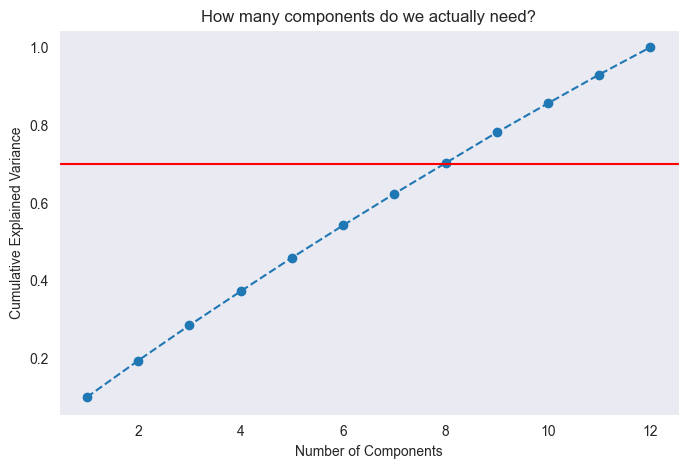

In [38]:
def variance_analysis(scaled_data,threshold):
    # Check how many components are needed to reach 70% variance
    full_pca = PCA().fit(scaled_data)
    cumulative_variance = np.cumsum(full_pca.explained_variance_ratio_)

    # Finding the number of components for the threshold
    n_threshold = np.where(cumulative_variance >= threshold)[0][0] + 1

    logger.info(f"To explain {threshold} of the variance, we would need {n_threshold} components.")

    # Plotting the "Scree Plot"
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.title('How many components do we actually need?')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()

# Execution
threshold = 0.7
variance_analysis(scaled_data,threshold)

# Scree Plot & Cumulative Variance
Due to the low correlation between clinical and lifestyle variables (as seen in the linear cumulative variance plot), we selected the first 3 components to capture the most dominant trends while maintaining interpretability.

2026-01-24 17:12:18,106 - INFO - To explain 0.7 of the variance, we would need 8 components.


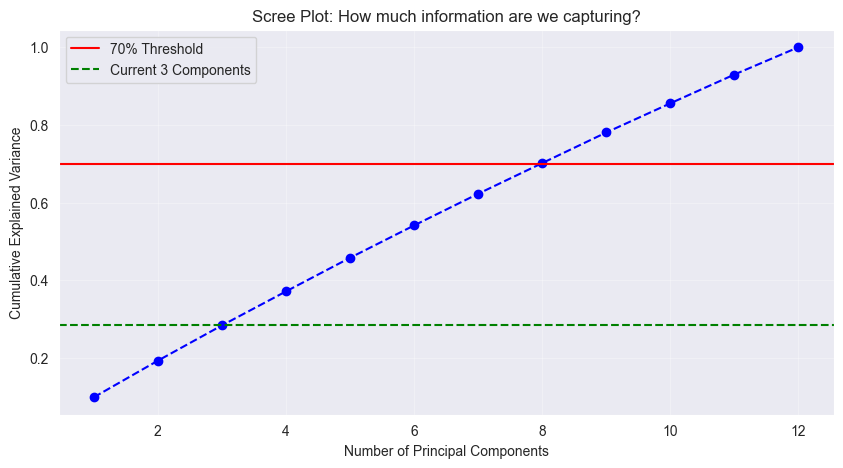

In [39]:
def scree_plot(scaled_data,threshold,total_variance):
    # 1. Run PCA without limiting the number of components to see the full picture
    full_pca = PCA().fit(scaled_data)
    cumulative_variance = np.cumsum(full_pca.explained_variance_ratio_)

    # 2. Find exactly how many components are needed for 70% threshold
    n_threshold = np.where(cumulative_variance >= threshold)[0][0] + 1
    logger.info(f"To explain {threshold} of the variance, we would need {n_threshold} components.")

    # 3. Visualization: The Scree Plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.axhline(y=threshold, color='r', linestyle='-', label='70% Threshold')
    plt.axhline(y=total_variance, color='g', linestyle='--', label='Current 3 Components')

    plt.title('Scree Plot: How much information are we capturing?')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Execution
threshold = 0.7
scree_plot(scaled_data,threshold, total_variance)


 # 3D Visualization of Patient Profiles

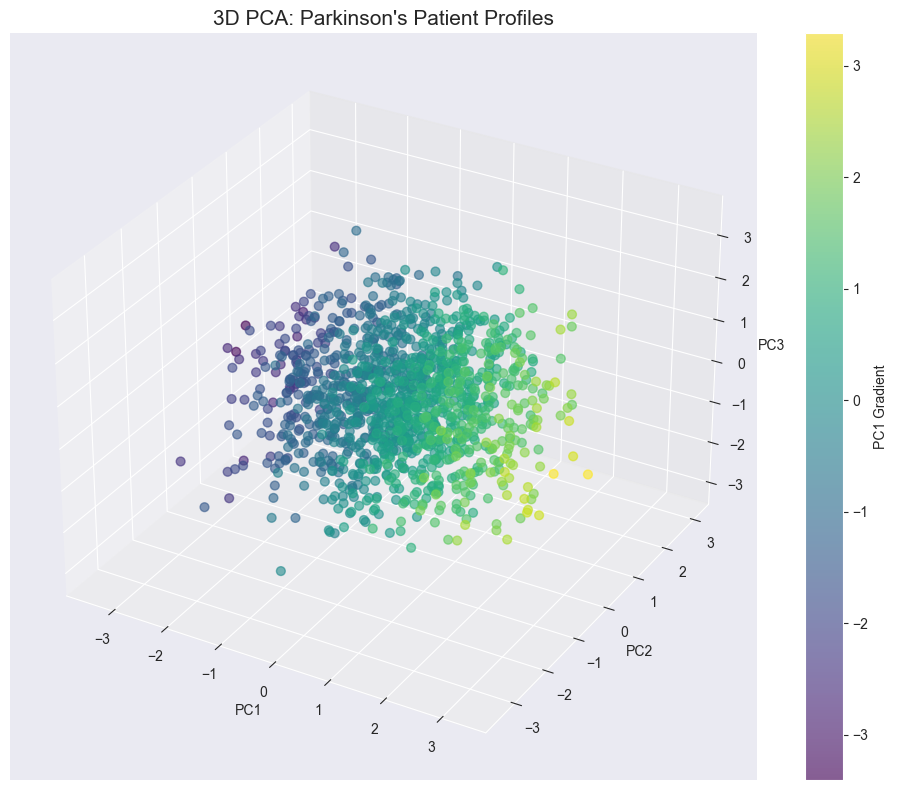

2026-01-24 17:12:18,251 - INFO - 3D Visualization created using Matplotlib.


In [40]:
def clusters_plot(df_pca_output):
    # 1. Create a 3D figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 2. Scatter plot
    # c=df_pca_output['PC1'] means it will color the points by their PC1 value (looks professional)
    sc = ax.scatter(df_pca_output['PC1'],
                    df_pca_output['PC2'],
                    df_pca_output['PC3'],
                    c=df_pca_output['PC1'],
                    cmap='viridis',
                    s=40,
                    alpha=0.6)

    # 3. Labels and Title
    ax.set_title("3D PCA: Parkinson's Patient Profiles", fontsize=15)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # 4. Add a color bar
    plt.colorbar(sc, label='PC1 Gradient')

    plt.tight_layout()
    plt.show()

    logger.info("3D Visualization created using Matplotlib.")

# Execution
clusters_plot(df_pca_output)

# The Elbow Method

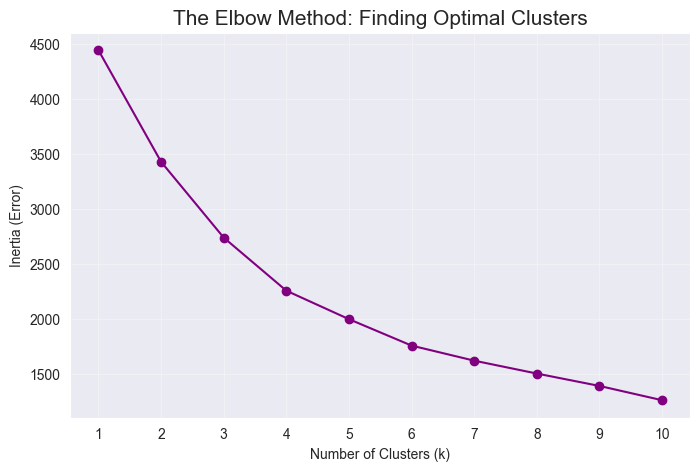

2026-01-24 17:12:18,360 - INFO - Elbow Method analysis completed.


In [41]:
def elbow_method(df_pca_output,pca_results):
    # 1. Calculate inertia for different numbers of clusters
    inertia = []
    K_range = range(1, 11) # Checking from 1 to 10 clusters

    for k in K_range:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(pca_results)
        inertia.append(km.inertia_)

    # 2. Plot the Elbow graph
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, inertia, marker='o', linestyle='-', color='purple')
    plt.title('The Elbow Method: Finding Optimal Clusters', fontsize=15)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Error)')
    plt.xticks(K_range)
    plt.grid(True, alpha=0.3)

    # Highlight the "Elbow"
    plt.show()

    logger.info("Elbow Method analysis completed.")

# Execution
elbow_method(df_pca_output,pca_results)

# K-Means Clustering

In [42]:
def k_means_clustering(df_pca_output,pca_results):
    # 1. Initialize the KMeans model
    # We choose 4 clusters to look for 4 distinct patient profiles
    kmeans = KMeans(n_clusters=4, random_state=42)

    # 2. Fit the model using our PCA results
    df_pca_output['Cluster'] = kmeans.fit_predict(pca_results)

    # 3. Log the success
    logger.info("Clustering complete. Patients have been assigned to 4 distinct profiles.")

    # 4. Let's see how many patients are in each cluster
    print(df_pca_output['Cluster'].value_counts())
    return df_pca_output

# Execution
k_means_clustering(df_pca_output,pca_results)

2026-01-24 17:12:18,381 - INFO - Clustering complete. Patients have been assigned to 4 distinct profiles.


Cluster
2    363
1    325
0    312
3    304
Name: count, dtype: int64


,PC1,PC2,PC3,Cluster
1,0.902693,0.371210,1.255069,2
2,-1.188047,0.194292,2.964120,3
3,1.051528,-0.904444,1.406671,2
7,-0.679002,-0.248408,-2.140275,0
8,1.179174,1.295203,-0.073477,1
...,...,...,...,...
2098,-0.795839,-1.113644,-0.022461,0
2099,0.821855,0.738021,-0.265359,1
2101,0.390033,-0.218289,-0.912273,0
2102,0.762492,-0.846069,0.965622,2


# Visualizing the Clusters in 3D

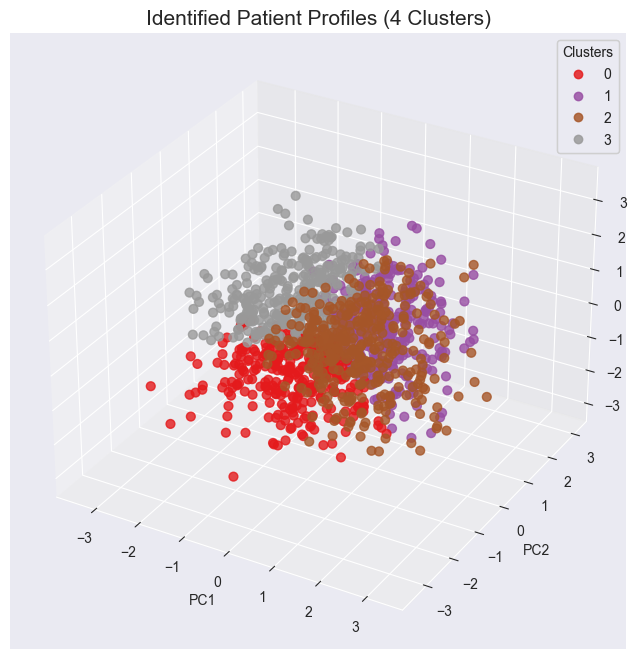

2026-01-24 17:12:18,499 - INFO - 3D Cluster Visualization created successfully.


In [43]:
def clusters_3d_plot(df_pca_output):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Color the points by their Cluster ID (0, 1, 2)
    scatter = ax.scatter(df_pca_output['PC1'],
                         df_pca_output['PC2'],
                         df_pca_output['PC3'],
                         c=df_pca_output['Cluster'], # This is the magic line!
                         cmap='Set1', # A colorful palette for distinct groups
                         s=40,
                         alpha=0.8)

    ax.set_title("Identified Patient Profiles (4 Clusters)", fontsize=15)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Add a legend to show which color is which Cluster
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)

    plt.show()

    logger.info("3D Cluster Visualization created successfully.")

# Execution
clusters_3d_plot(df_pca_output)


# Cluster Profiling

In [44]:
def cluster_profile(df_pca,df_pca_output):
    # 1. Add the Cluster labels back to the ORIGINAL dataframe (the one with real units)
    df_pca['Cluster'] = df_pca_output['Cluster']

    # 2. Calculate the mean (average) for each variable per cluster
    cluster_profiles = df_pca.groupby('Cluster').mean()

    # 3. Display the results
    print("Profiles for each Cluster (Mean Values):")
    display(cluster_profiles)

    # 4. Save the results to a CSV file to use in your presentation slides
    cluster_profiles.to_csv("patient_profiles_summary.csv")
    logger.info("Cluster profiling complete. Summary saved to CSV.")

    return cluster_profiles

# Execution
cluster_profiles = cluster_profile(df_pca,df_pca_output)

Profiles for each Cluster (Mean Values):


,Age,BMI,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides
Cluster,,,,,,,,,,,,
0,70.108974,30.779556,13.648003,4.531703,5.837804,7.077657,123.794872,84.910256,213.801861,111.945198,44.397440,190.353336
1,76.763077,30.201481,7.866033,6.309163,4.311340,6.396016,140.772308,100.363077,229.426332,138.170278,52.588204,254.724536
2,62.410468,22.409206,9.603002,4.621159,4.229347,6.336268,145.162534,92.592287,212.828584,125.549785,66.331076,202.040580
3,72.559211,26.808303,9.886253,4.730648,5.201040,8.089034,122.309211,80.453947,251.492599,130.731145,73.421510,252.707840


2026-01-24 17:12:18,528 - INFO - Cluster profiling complete. Summary saved to CSV.


# Creation of a Heat map for clusters
We normalized the mean values across clusters using Z-score standardization to allow for a direct comparison. In this heatmap, a value of 0 represents the overall population mean. Red cells indicate values significantly above the average, while blue cells represent values below the average.

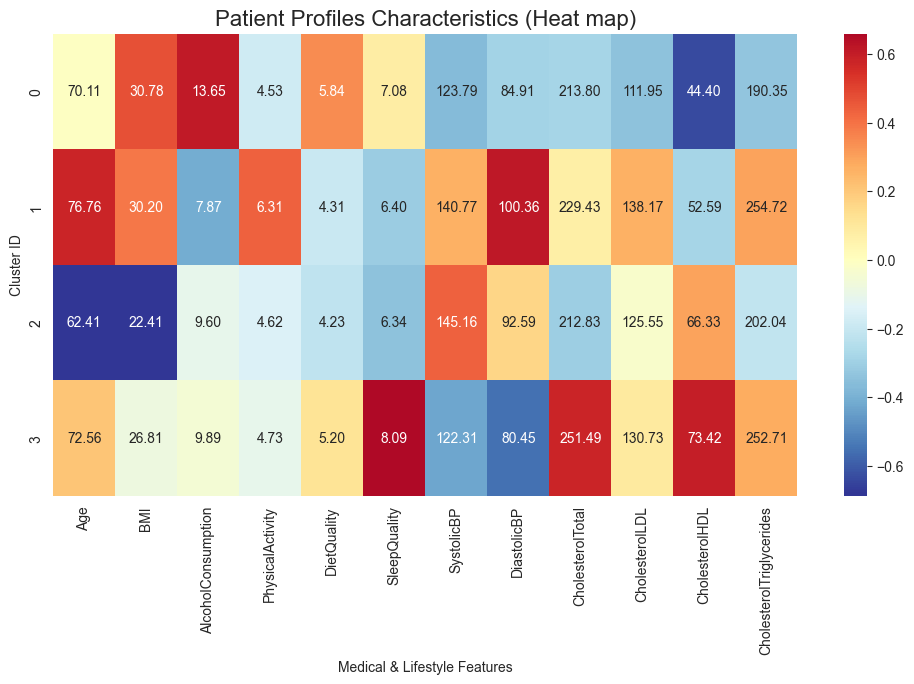

2026-01-24 17:12:18,655 - INFO - Visual profile summary created.


In [45]:
def cluster_heat_map(df_pca,cluster_profiles):
    #Heat map preparing : gives a Z-Score for every cluster_profile-feature-mean
    df_pca_original = df_pca.drop(columns=['Cluster'])
    cluster_profiles_norm = (cluster_profiles - df_pca_original.mean()) / df_pca_original.std()

    # Creating Heat map
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_profiles_norm,annot=cluster_profiles, cmap='RdYlBu_r', center=0, fmt = '.2f')
    plt.title("Patient Profiles Characteristics (Heat map)", fontsize=16)
    plt.ylabel("Cluster ID")
    plt.xlabel("Medical & Lifestyle Features")
    plt.show()

    logger.info("Visual profile summary created.")

# Execution
cluster_heat_map(df_pca,cluster_profiles)

# Differences between Clusters per Assessment
We choose to make an one-way ANOVA test for Clusters per Assessment. After this, we pick to do 'Pairwise comparisons': Tests all possible pairs.

In [46]:
def clusters_per_assessment(new_path,df_pca,):
    df = pd.read_csv(new_path)
    # Keep only the sick patients in the data frame.
    df = df[df['Diagnosis'] != 0]

    # Here We are doing the statistical test
    our_p_value = 0.20
    print(f"One-way analysis of variance\nH0: Samples in all groups are drawn from populations with the same mean values.\n Our critical P-value (alpha): {our_p_value}\n(We took this p_value because the data is synthetic...)\n")

    for assessment in ["UPDRS", "MoCA", "FunctionalAssessment"]:
        df_corr = pd.concat([df_pca['Cluster'], df[assessment]], axis=1)
        f_statistic, p_value = f_oneway(df_corr[df_corr['Cluster'] == 0][assessment],df_corr[df_corr['Cluster'] == 1][assessment],df_corr[df_corr['Cluster'] == 2][assessment],df_corr[df_corr['Cluster'] == 3][assessment])
        print(f"{assessment}\nF-statistic: {round(f_statistic,3)}\nP-value: {round(p_value,3)}")
        if p_value >= our_p_value:
            print(f"Not significant, we cannot reject the null hypothesis.\n")
        else:
            print(f"Significant! We can reject the null hypothesis.")
            print(f"We need to do a Post hoc analysis.\nWe pick to do 'Pairwise comparisons': Tests all possible pairs.\nDon't forget to counteract the multiple comparisons problem.\nSo we are doing the 'Bonferroni correction'")
            our_new_p_value = our_p_value/comb(len(df_pca['Cluster'].unique()),2)
            print(f"Our new critical P-value (alpha): {round(our_new_p_value,3)}")
            our_new_p_value = our_new_p_value/2
            print(f"We need to divide this by two because the test is two-tailed.")
            print(f"Our new critical P-value (alpha): {round(our_new_p_value,3)}")
            couple_of_clusters = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
            for couple in couple_of_clusters:
                t_stat, t_p_value = ttest_ind(df_corr[df_corr['Cluster'] == couple[0]][assessment],df_corr[df_corr['Cluster'] == couple[1]][assessment])
                print(f"{couple[0]},{couple[1]}: {round(t_p_value,3)}")
                if t_p_value >= our_new_p_value:
                    print(f"Not significant.")
                else:
                    print(f"Significant!")
            print("\n")
    logger.info("One way analysis of variance complete.")


# Execution
another_path = "../../data/parkinsons_cleaned.csv"
clusters_per_assessment(another_path,df_pca)

2026-01-24 17:12:18,679 - INFO - One way analysis of variance complete.


One-way analysis of variance
H0: Samples in all groups are drawn from populations with the same mean values.
 Our critical P-value (alpha): 0.2
(We teke this p_value because the data is synthetic...)

UPDRS
F-statistic: 1.404
P-value: 0.24
Not significant, we cannot reject the null hypothesis.

MoCA
F-statistic: 1.094
P-value: 0.351
Not significant, we cannot reject the null hypothesis.

FunctionalAssessment
F-statistic: 1.749
P-value: 0.155
Significant! We can reject the null hypothesis.
We need to do a Post hoc analysis.
We pick to do 'Pairwise comparisons': Tests all possible pairs.
Don't forget to counteract the multiple comparisons problem.
So we are doing the 'Bonferroni correction'
Our new critical P-value (alpha): 0.033
We need to divide this by two because the test is two-tailed.
Our new critical P-value (alpha): 0.017
0,1: 0.789
Not significant.
0,2: 0.125
Not significant.
0,3: 0.6
Not significant.
1,2: 0.07
Not significant.
1,3: 0.799
Not significant.
2,3: 0.037
Not signific